# Partial History

Code to generate figure 3 in the event-based-neuron manuscript.

Receives data generated from `partial_history.py` in the `scripts` folder.

The partial histories scripts first generate stimuli patterns, then random cell histories (state variable frames) and then run experiments simulating the combination of each of the stimuli patterns with each of the histories with each value of n for n inputs. The results allow for the statistical analysis of response distributions given ambiguity in initial conditions and differing quanta of input stimuli. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from scipy import stats
import matplotlib.lines as lines

sys.path.insert(1, "../utils/")
import HH, Stimuli

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

In [5]:
data_dirs = [
    '../data/partial_history/results/',
    '../data/partial_history/results_mccleary/'
]
figures_dir = '../figures/'

In [6]:
results_files = []
for data_dir in data_dirs:
    results_files.extend([data_dir+file for file in os.listdir(f'{data_dir}')])

stim_types = ['base','lw','lt','lwlt','burst','wb']

## load data
Data generated from `partial_history.py` in the `scripts` folder.

In [10]:
ns = list(range(3,51))

results = {
    'base':{n:{} for n in ns},
    'lw':{n:{} for n in ns},
    'lt':{n:{} for n in ns},
    'lwlt':{n:{} for n in ns},
    'burst':{n:{} for n in ns},
    'wb':{n:{} for n in ns},
}

progress = 0.0
print('______PROGRESS______')
for i, results_file in enumerate(results_files):
    _results_file = results_file.split('/')[-1]
    stim_type = _results_file.split('_')[0]
    n = int(_results_file.split('_')[1])
    pattern_id = int(_results_file.split('_')[2].strip('.npy'))    
    results[stim_type][n][pattern_id] = np.load(f'{results_file}')
    
    if i / len(results_files) > progress:
        progress += 0.05
        print('=', end='')


______PROGRESS______

## begin analysis

In [11]:
def calc_spike_presence_prediction_acc(df):
    no_spike = np.sum(np.isnan(df))
    spike = df.shape[0] - no_spike
    return (no_spike/df.shape[0])**2 + (spike/df.shape[0])**2

def calc_nst_std(df):
    return np.std(df[~np.isnan(df)])

def calc_nst_mae(df):
    _df = df[~np.isnan(df)]
    return np.nanmean(np.abs(_df - np.mean(_df)))

In [12]:
spike_presence_prediction_accs = {
    'base': {n:[] for n in ns},
    'lw': {n:[] for n in ns},
    'lt': {n:[] for n in ns},
    'lwlt': {n:[] for n in ns},
    'burst': {n:[] for n in ns},
    'wb': {n:[] for n in ns}
}
nst_stds = {
    'base': {n:[] for n in ns},
    'lw': {n:[] for n in ns},
    'lt': {n:[] for n in ns},
    'lwlt': {n:[] for n in ns},
    'burst': {n:[] for n in ns},
    'wb': {n:[] for n in ns},
}
nst_maes = {
    'base': {n:[] for n in ns},
    'lw': {n:[] for n in ns},
    'lt': {n:[] for n in ns},
    'lwlt': {n:[] for n in ns},
    'burst': {n:[] for n in ns},
    'wb': {n:[] for n in ns},
}

for stim_type in results:
    for n in ns:
        for pattern_ind in range(1000):
            try:
                df = results[stim_type][n][pattern_ind]
                spike_presence_prediction_accs[stim_type][n].append(calc_spike_presence_prediction_acc(df))
                nst_stds[stim_type][n].append(calc_nst_std(df))
                nst_maes[stim_type][n].append(calc_nst_mae(df))
            except:
                pass

/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_392642/1350620721.py:11: Runti

In [13]:
spike_presence_prediction_acc_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
nst_std_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
nst_mae_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}

for stim_type in spike_presence_prediction_accs:
    for n in ns:
        spike_presence_prediction_acc_means[stim_type].append(np.mean(spike_presence_prediction_accs[stim_type][n]))
        
        nst_std_means[stim_type].append(np.nanmean(nst_stds[stim_type][n]))
        
        nst_mae_means[stim_type].append(np.nanmean(nst_maes[stim_type][n]))

/tmp/ipykernel_392642/3663058496.py:30: RuntimeWarning: Mean of empty slice
  nst_std_means[stim_type].append(np.nanmean(nst_stds[stim_type][n]))
/tmp/ipykernel_392642/3663058496.py:32: RuntimeWarning: Mean of empty slice
  nst_mae_means[stim_type].append(np.nanmean(nst_maes[stim_type][n]))


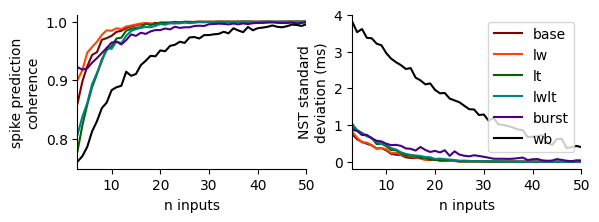

In [28]:
colors = {
    'base': 'maroon',
    'lw': 'orangered',
    'lt': 'darkgreen',
    'lwlt': 'teal',
    'burst': 'indigo',
    'wb':'black'
}

fig, axes = plt.subplots(1,2, figsize=(6.5,2), sharex=True)
for stim_type in spike_presence_prediction_acc_means:
    axes[0].plot(ns, spike_presence_prediction_acc_means[stim_type], c=colors[stim_type])
    
    axes[1].plot(ns, nst_std_means[stim_type], c=colors[stim_type])

axes[-1].set_xlim(3,50)

axes[0].set_ylabel('spike prediction\ncoherence')
axes[1].set_ylabel('NST standard\ndeviation (ms)')
axes[0].set_xlabel('n inputs')
axes[1].set_xlabel('n inputs')
axes[1].legend(list(colors.keys()))

axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)

savefig = True
if savefig:
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.svg', format='svg')
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.png', format='png', dpi=300)

plt.show()

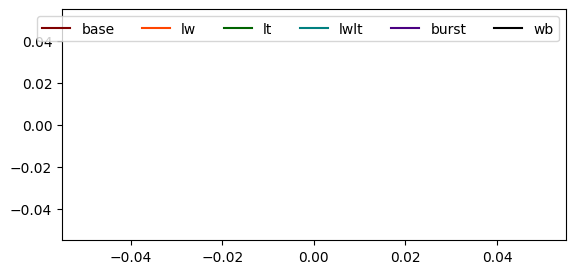

In [37]:
plt.figure(figsize=(6.5, 3))
for stim_type in colors:
    plt.plot(0,0,colors[stim_type])
plt.legend(list(colors.keys()), ncol=6)
plt.savefig(f'{figures_dir}spike_prediction_and_nst_std_legend.svg', format='svg')

In [39]:
spike_rates = {
    'base': {n:[] for n in ns},
    'lw': {n:[] for n in ns},
    'lt': {n:[] for n in ns},
    'lwlt': {n:[] for n in ns},
    'burst': {n:[] for n in ns},
    'wb': {n:[] for n in ns}
}
nsts = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
for stim_type in results:
    for n in ns:
        for pattern_ind in results[stim_type][n]:
            _nsts = list(results[stim_type][n][pattern_ind][~np.isnan(results[stim_type][n][pattern_ind])])
            nsts[stim_type].extend(_nsts)
            spike_rates[stim_type][n].append(len(_nsts)/1000)

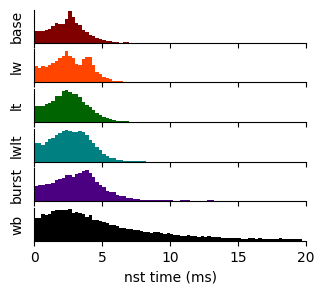

<Figure size 640x480 with 0 Axes>

In [50]:
fig, axes = plt.subplots(len(nsts), 1, sharex=True, figsize=(3.5,3))

bins=np.arange(0,20,.25)
for i, stim_type in enumerate(nsts):
    axes[i].hist(nsts[stim_type], bins = bins, color=colors[stim_type])
    axes[i].set_yticks([])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_ylabel(stim_type)
axes[-1].set_xlim(0, 20)
axes[-1].set_xlabel('nst time (ms)')
plt.show()

savefig = True
if savefig:
    plt.savefig(f'{figures_dir}nst_distributions.svg', format='svg')
    plt.savefig(f'{figures_dir}nst_distributions.png', format='png', dpi=300)